In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf

def convert_sample(sample):
    image, label = sample['image'], sample['label']  
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, image  

def map_func(sample):
    image = sample['image']
    label = sample['label']
    label = tf.one_hot(label, 2, dtype=tf.float32)
    return image, label

ds1, ds2, ds3 = tfds.load('patch_camelyon',
                         split=['train[:10%]', 'test[:3%]', 'validation[:3%]'],
                         data_dir=r'C:\\Job_og_eksamensbevis\\Github\\projekter\\Projekt_1_Computer_Vision\path_to_data_directory',
                         download=False,
                         shuffle_files=True)

train_dataset       = ds1.map(convert_sample).batch(32)
validation_dataset  = ds3.map(convert_sample).batch(32)
test_dataset        = ds2.map(convert_sample).batch(32)

train_dataset_cnn       = ds1.map(map_func).batch(32)
validation_dataset_cnn  = ds3.map(map_func).batch(32)
test_dataset_cnn        = ds2.map(map_func).batch(32)

 

In [5]:
from tensorflow.keras import layers, Model
from tensorflow.keras.losses import MeanSquaredError

# Define the encoder part
class Encoder(tf.keras.layers.Layer): 
    def __init__(self, latent_dim): 
        super(Encoder, self).__init__()
        self.conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')
        self.maxpool1 = layers.MaxPooling2D((2, 2), padding='same')
        self.conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')
        self.maxpool2 = layers.MaxPooling2D((2, 2), padding='same')
        self.flatten = layers.Flatten()
        self.dense_mean = layers.Dense(latent_dim)
        self.dense_log_var = layers.Dense(latent_dim)

    def call(self, x): 
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.flatten(x)
        mean = self.dense_mean(x)
        log_var = self.dense_log_var(x)
        return mean, log_var

# Define the decoder part
class Decoder(tf.keras.layers.Layer):
    def __init__(self, latent_dim, original_shape):
        super(Decoder, self).__init__()
        self.dense = layers.Dense(units=original_shape[0] * original_shape[1] * original_shape[2], activation=tf.nn.relu)
        self.reshape = layers.Reshape(target_shape=(original_shape[0], original_shape[1], original_shape[2]))
        self.conv2dtranspose1 = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')
        self.conv2dtranspose2 = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')
        self.conv2dtranspose3 = layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')

    def call(self, z):
        z = self.dense(z)
        z = self.reshape(z)
        z = self.conv2dtranspose1(z)
        z = self.conv2dtranspose2(z)
        reconstructed = self.conv2dtranspose3(z)
        return reconstructed

# Define the Variational Autoencoder as a whole
class VAE(Model):
    def __init__(self, latent_dim, original_shape):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim, original_shape)

    def sample(self, mean, log_var):
        batch = tf.shape(mean)[0]
        dim = tf.shape(mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return mean + tf.exp(0.5 * log_var) * epsilon

    def call(self, x):
        mean, log_var = self.encoder(x)
        z = self.sample(mean, log_var)
        reconstructed = self.decoder(z)
        return reconstructed

# Set the latent dimension and original image shape
latent_dim = 128
original_shape = (96, 96, 3)  

# Instantiate the VAE
vae = VAE(latent_dim, original_shape)

# Compile the model
vae.compile(optimizer='adam', loss=MeanSquaredError())

# Freeze the layers in the encoder
vae.encoder.conv1.trainable = False
vae.encoder.maxpool1.trainable = False
vae.encoder.conv2.trainable = False
vae.encoder.maxpool2.trainable = False
vae.encoder.flatten.trainable = False
vae.encoder.dense_mean.trainable = False
vae.encoder.dense_log_var.trainable = False


vae.fit(
        train_dataset,
        epochs=5, 
        validation_data=validation_dataset
)


Epoch 1/5
 30/820 [>.............................] - ETA: 5:25 - loss: 0.0599

KeyboardInterrupt: 

Epoch 1/5
820/820 [==============================] - 203s 246ms/step - loss: 0.0739 - val_loss: 0.0639
Epoch 2/5
820/820 [==============================] - 200s 244ms/step - loss: 0.0610 - val_loss: 0.0598
Epoch 3/5
820/820 [==============================] - 203s 248ms/step - loss: 0.0594 - val_loss: 0.0596
Epoch 4/5
820/820 [==============================] - 198s 241ms/step - loss: 0.0593 - val_loss: 0.0596
Epoch 5/5
820/820 [==============================] - 206s 251ms/step - loss: 0.0593 - val_loss: 0.0596
Epoch 1/5
820/820 [==============================] - 227s 275ms/step - loss: 0.0591 - val_loss: 0.0595
Epoch 2/5
820/820 [==============================] - 222s 270ms/step - loss: 0.0584 - val_loss: 0.0587
Epoch 3/5
820/820 [==============================] - 213s 259ms/step - loss: 0.0582 - val_loss: 0.0580
Epoch 4/5
820/820 [==============================] - 208s 253ms/step - loss: 0.0582 - val_loss: 0.0594
Epoch 5/5
820/820 [==============================] - 222s 271ms/step - lo

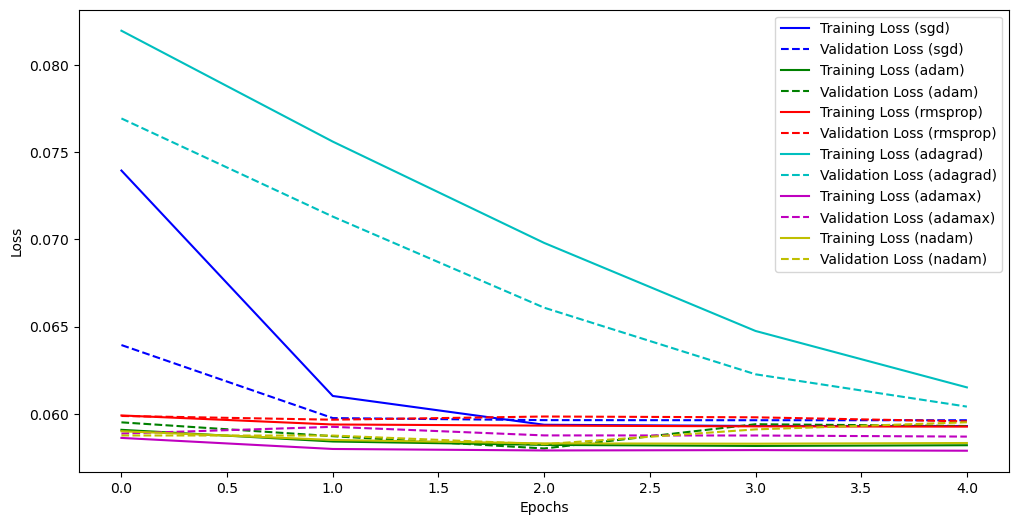

In [13]:
#tester den bedste optimizer på baselinemodellen
import tensorflow.compat.v1 as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, Adadelta, Adamax, Nadam, RMSprop
import matplotlib.pyplot as plt

# Your provided VAE classes (Encoder, Decoder, VAE) go here

import tensorflow.compat.v1 as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.losses import MeanSquaredError

# Define the encoder part
class Encoder(tf.keras.layers.Layer): 
    def __init__(self, latent_dim): 
        super(Encoder, self).__init__()
        self.conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')
        self.maxpool1 = layers.MaxPooling2D((2, 2), padding='same')
        self.conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')
        self.maxpool2 = layers.MaxPooling2D((2, 2), padding='same')
        self.flatten = layers.Flatten()
        self.dense_mean = layers.Dense(latent_dim)
        self.dense_log_var = layers.Dense(latent_dim)

    def call(self, x): 
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.flatten(x)
        mean = self.dense_mean(x)
        log_var = self.dense_log_var(x)
        return mean, log_var

# Define the decoder part
class Decoder(tf.keras.layers.Layer):
    def __init__(self, latent_dim, original_shape):
        super(Decoder, self).__init__()
        self.dense = layers.Dense(units=original_shape[0] * original_shape[1] * original_shape[2], activation=tf.nn.relu)
        self.reshape = layers.Reshape(target_shape=(original_shape[0], original_shape[1], original_shape[2]))
        self.conv2dtranspose1 = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')
        self.conv2dtranspose2 = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')
        self.conv2dtranspose3 = layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')

    def call(self, z):
        z = self.dense(z)
        z = self.reshape(z)
        z = self.conv2dtranspose1(z)
        z = self.conv2dtranspose2(z)
        reconstructed = self.conv2dtranspose3(z)
        return reconstructed

# Define the Variational Autoencoder as a whole
class VAE(Model):
    def __init__(self, latent_dim, original_shape):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim, original_shape)

    def sample(self, mean, log_var):
        batch = tf.shape(mean)[0]
        dim = tf.shape(mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return mean + tf.exp(0.5 * log_var) * epsilon

    def call(self, x):
        mean, log_var = self.encoder(x)
        z = self.sample(mean, log_var)
        reconstructed = self.decoder(z)
        return reconstructed

# Set the latent dimension and original image shape
latent_dim = 128
original_shape = (96, 96, 3) 

# List of optimizers to compare
optimizers = ['sgd', 'adam', 'rmsprop', 'adagrad', 'adamax', 'nadam']

# Plot colors for each optimizer
colors = ['b', 'g', 'r', 'c', 'm', 'y']

# Initialize subplots
plt.figure(figsize=(12, 6))

for i, optimizer in enumerate(optimizers):
    # Instantiate the VAE
    vae = VAE(latent_dim, original_shape)
    
     # Freeze the layers in the encoder
    vae.encoder.conv1.trainable = False
    vae.encoder.maxpool1.trainable = False
    vae.encoder.conv2.trainable = False
    vae.encoder.maxpool2.trainable = False
    vae.encoder.flatten.trainable = False
    vae.encoder.dense_mean.trainable = False
    vae.encoder.dense_log_var.trainable = False

    # Compile the model with the current optimizer
    vae.compile(optimizer=optimizer, loss=MeanSquaredError())

    # Train the VAE
    history = vae.fit(
        train_dataset,
        epochs=5,  
        batch_size=256,
        shuffle=True,
        validation_data=validation_dataset,
        callbacks=[TensorBoard(log_dir=f'/tmp/vae_{optimizer}'), EarlyStopping(monitor='val_loss', patience=3)]
    )

    # Access the training history
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Plot the training progress for the current optimizer
    plt.plot(loss, label=f'Training Loss ({optimizer})', linestyle='-', color=colors[i])
    plt.plot(val_loss, label=f'Validation Loss ({optimizer})', linestyle='--', color=colors[i])

# Set plot labels and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



CNN med L1

In [18]:
#her er latent dim udskiftet til original shape. Original shape = 96,96,3
from tensorflow.keras.regularizers import l1_l2

def build_cnn(vae, original_shape):
    # Create a new input layer that matches the original input
    cnn_input = layers.Input(shape=original_shape)

    # Print the shape of cnn_input
    print("Shape of cnn_input:", cnn_input.shape)

    # Get the mean vector from the encoder
    mean, _ = vae.encoder(cnn_input)

    # Initialize 'x' with the input tensor
    x = cnn_input

    # Build CNN layers for classification
    x = Conv2D(32, kernel_size=(3, 3), activation="relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64, kernel_size=(3, 3), activation="relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)

    # Flatten the output of the CNN before feeding into dense layers
    x = Flatten()(x)

    # Combine with mean vector - if necessary, reshape or process 'mean' to match dimensions
    x = layers.concatenate([x, mean])

    # Continue with dense layers
    x = Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=0.00001))(x)
    x = Dense(64, activation="relu"),(x)
    cnn_output = Dense(2, activation="softmax")(x)  # Output layer for 2 classes

    # Create model
    cnn_model = Model(inputs=cnn_input, outputs=cnn_output)
    
    print("Shape of cnn_input:", cnn_input.shape)
    
    return cnn_model


CNN med L2

In [ ]:
#her er latent dim udskiftet til original shape. Original shape = 96,96,3
from tensorflow.keras.regularizers import l1_l2

def build_cnn(vae, original_shape):
    # Create a new input layer that matches the original input
    cnn_input = layers.Input(shape=original_shape)

    # Print the shape of cnn_input
    print("Shape of cnn_input:", cnn_input.shape)

    # Get the mean vector from the encoder
    mean, _ = vae.encoder(cnn_input)

    # Initialize 'x' with the input tensor
    x = cnn_input

    # Build CNN layers for classification
    x = Conv2D(32, kernel_size=(3, 3), activation="relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64, kernel_size=(3, 3), activation="relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)

    # Flatten the output of the CNN before feeding into dense layers
    x = Flatten()(x)

    # Combine with mean vector - if necessary, reshape or process 'mean' to match dimensions
    x = layers.concatenate([x, mean])

    # Continue with dense layers
    x = Dense(128, activation='relu', kernel_regularizer=l1_l2(l2=0.00001))(x)
    x = Dense(64, activation="relu"),(x)
    cnn_output = Dense(2, activation="softmax")(x) 

    # Create model
    cnn_model = Model(inputs=cnn_input, outputs=cnn_output)
    
    print("Shape of cnn_input:", cnn_input.shape)
    
    return cnn_model


Med dropout 0.2

In [ ]:
def build_cnn(vae, original_shape):
    # Create a new input layer that matches the original input
    cnn_input = layers.Input(shape=original_shape)

    # Print the shape of cnn_input
    print("Shape of cnn_input:", cnn_input.shape)

    # Get the mean vector from the encoder
    mean, _ = vae.encoder(cnn_input)

    # Initialize 'x' with the input tensor
    x = cnn_input

    # Build CNN layers for classification
    x = Conv2D(32, kernel_size=(3, 3), activation="relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64, kernel_size=(3, 3), activation="relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)

    # Flatten the output of the CNN before feeding into dense layers
    x = Flatten()(x)

    # Combine with mean vector 
    x = layers.concatenate([x, mean])

    # Continue with dense layers
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation="relu")(x)
    
    # Add dropout layer with a rate of 0.2
    x = Dropout(0.2)(x)
    
    cnn_output = Dense(2, activation="softmax")(x)  # Output layer for 2 classes

    # Create model
    cnn_model = Model(inputs=cnn_input, outputs=cnn_output)
    
    print("Shape of cnn_input:", cnn_input.shape)
    
    return cnn_model

In [17]:
#-------> ved ikke om den her del er nødvendig, tror Original shape fra den her del skal være defineret for at resten virker

latent_dim = 128  # or whatever your latent dimension is
original_shape = (96, 96, 3)  # Assuming this is the shape of your input data
cnn_model = build_cnn(vae, original_shape)



Shape of cnn_input: (None, 96, 96, 3)


TypeError: Inputs to a layer should be tensors. Got '<keras.src.layers.core.dense.Dense object at 0x0000018CB1B91750>' (of type <class 'keras.src.layers.core.dense.Dense'>) as input for layer 'dense_20'.

In [5]:
#Igen her er latent dim ændret til original shape. Original shape = 96,96,3
# Build and compile the CNN model
cnn_model = build_cnn(vae, original_shape)
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training the CNN model
history = cnn_model.fit(
    train_dataset_cnn, 
    epochs=20,          
    validation_data=validation_dataset_cnn,
   )# Your validation dataset

# Evaluate the CNN model
accuracy = cnn_model.evaluate(test_dataset_cnn, verbose=1)

Shape of cnn_input: (None, 96, 96, 3)


TypeError: Inputs to a layer should be tensors. Got '<keras.src.layers.core.dense.Dense object at 0x0000018CE03F1FF0>' (of type <class 'keras.src.layers.core.dense.Dense'>) as input for layer 'dense_5'.

In [10]:

print(vae.summary())

for data, _ in train_dataset_cnn.take(1):
    print("Shape of the data being fed into the model:", data.shape)


Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           ((None, 128),             9456832   
                              (None, 128))                       
                                                                 
 decoder (Decoder)           multiple                  3587715   
                                                                 
Total params: 13044547 (49.76 MB)
Trainable params: 3587715 (13.69 MB)
Non-trainable params: 9456832 (36.07 MB)
_________________________________________________________________
None
Shape of the data being fed into the model: (32, 96, 96, 3)


In [11]:
test_loss, test_accuracy = cnn_model.evaluate(test_dataset_cnn)
print(f"Test accuracy: {test_accuracy}, Test loss: {test_loss}")


NameError: name 'cnn_model' is not defined

NameError: name 'history' is not defined

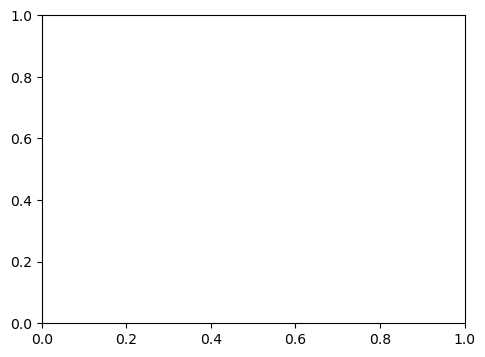

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()

tester bedste optimizer på VAE-CNN

In [40]:
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad, Adadelta, Adamax, Nadam

# List of optimizers to test
optimizers = {
    'Adam': Adam(),
    'SGD': SGD(),
    'RMSprop': RMSprop(),
    'Adagrad': Adagrad(),
    'adamax': Adamax(),
    'Nadam': Nadam()
}

# Dictionaries to store history for each optimizer
history_dict_accuracy = {}
history_dict_loss = {}

# Loop over the optimizers
for name, optimizer in optimizers.items():
    print(f"Training with {name} optimizer")

    # Build and compile the CNN model
    cnn_model = build_cnn(vae, original_shape)
    cnn_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Training the CNN model
    history = cnn_model.fit(
        train_dataset_cnn,
        epochs=5,
        validation_data=validation_dataset_cnn,
    )

    # Store the accuracy and loss
    history_dict_accuracy[name] = history.history['val_accuracy']
    history_dict_loss[name] = history.history['val_loss']

# Plotting Accuracy
plt.figure(figsize=(12, 6))
for name, val_accuracy in history_dict_accuracy.items():
    plt.plot(val_accuracy, label=f'{name} Accuracy')

plt.title('Model Validation Accuracy with Different Optimizers')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plotting Loss
plt.figure(figsize=(12, 6))
for name, val_loss in history_dict_loss.items():
    plt.plot(val_loss, label=f'{name} Loss')

plt.title('Model Validation Loss with Different Optimizers')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


Training with Adam optimizer
Shape of cnn_input: (None, 96, 96, 3)
Shape of cnn_input: (None, 96, 96, 3)
Epoch 1/5
603/820 [=====================>........] - ETA: 31s - loss: 3.6550 - accuracy: 0.6072